In [12]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

train_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/train"
val_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/val"
test_dir = "데이터셋/한국인 감정인식을 위한 복합 영상/최종데이터셋/test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'    )

Found 67471 images belonging to 7 classes.
Found 14458 images belonging to 7 classes.
Found 14459 images belonging to 7 classes.


In [13]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
model = Sequential()

model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(7, activation='softmax'))

In [14]:
model.load_weights("v2_final.hdf5")

In [41]:
model.output

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_5')>

In [40]:
from keras.models import Model
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


feature_model = Model(inputs=model.input, outputs=model.layers[-6].output)  

def extract_features(generator, sample_count):
    features = np.zeros((sample_count, feature_model.output_shape[1]))
    labels = np.zeros((sample_count, 7))  
    i = 0

    for inputs_batch, labels_batch in tqdm(generator, total=sample_count // generator.batch_size):
        batch_size = inputs_batch.shape[0] 
        features_batch = feature_model.predict(inputs_batch, verbose=0)

        features[i * generator.batch_size : i * generator.batch_size + batch_size] = features_batch
        labels[i * generator.batch_size : i * generator.batch_size + batch_size] = labels_batch
        i += 1

        if i * generator.batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_generator, 67471)




  0%|          | 0/2108 [00:00<?, ?it/s]

100%|██████████| 2108/2108 [03:32<00:00,  9.91it/s]


In [42]:
svd = TruncatedSVD(n_components=2)
train_svd = svd.fit_transform(train_features)

In [43]:
pca = IncrementalPCA(n_components=2)
train_pca = pca.fit_transform(train_features)

In [58]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'Malgun Gothic'


def plot_representation(data, labels, title='2D representation'):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))  
    fig.suptitle(title)

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange'] 
    emotions_korean = ["분노", "슬픔", "불안", "상처", "당황", "기쁨", "중립"]


    ax = axes[0, 0]
    for i in range(7): 
        indices = np.where(labels[:, i] == 1)[0]
        ax.scatter(data[indices, 0], data[indices, 1], c=colors[i], label=emotions_korean[i],alpha=0.3)
    ax.set_title('모든 감정')
    ax.set_xlim(-10, 20)
    ax.set_ylim(-10, 20)
    ax.legend()


    for i in range(7):
        ax = axes[(i+1)//4, (i+1)%4]  
        indices = np.where(labels[:, i] == 1)[0]
        ax.scatter(data[indices, 0], data[indices, 1], c=colors[i])
        ax.set_title(emotions_korean[i])
        ax.set_xlim(-10, 20)
        ax.set_ylim(-10, 20)

    plt.tight_layout()
    plt.show()

C:\Users\guhyu\AppData\Local\Temp\ipykernel_17312\2977233200.py:32: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


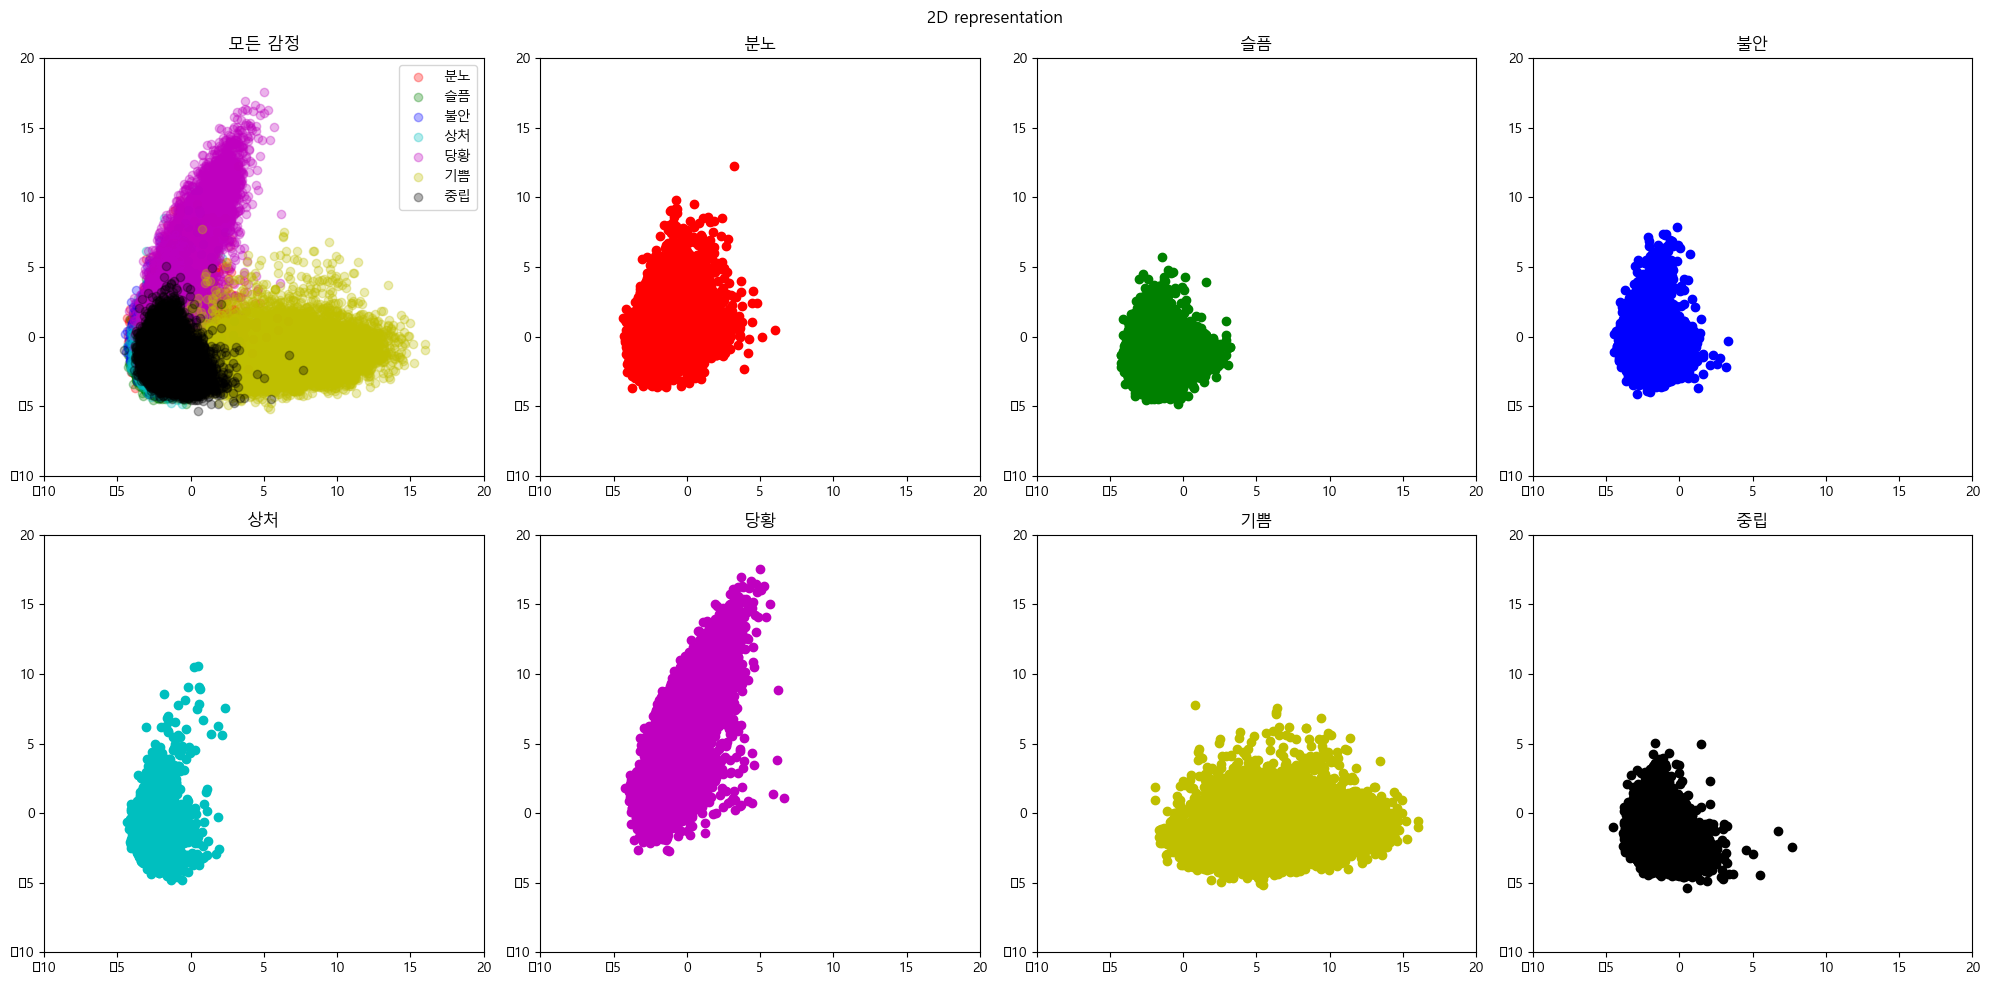

In [59]:
plot_representation(train_pca, train_labels)

C:\Users\guhyu\AppData\Local\Temp\ipykernel_17312\2977233200.py:32: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()


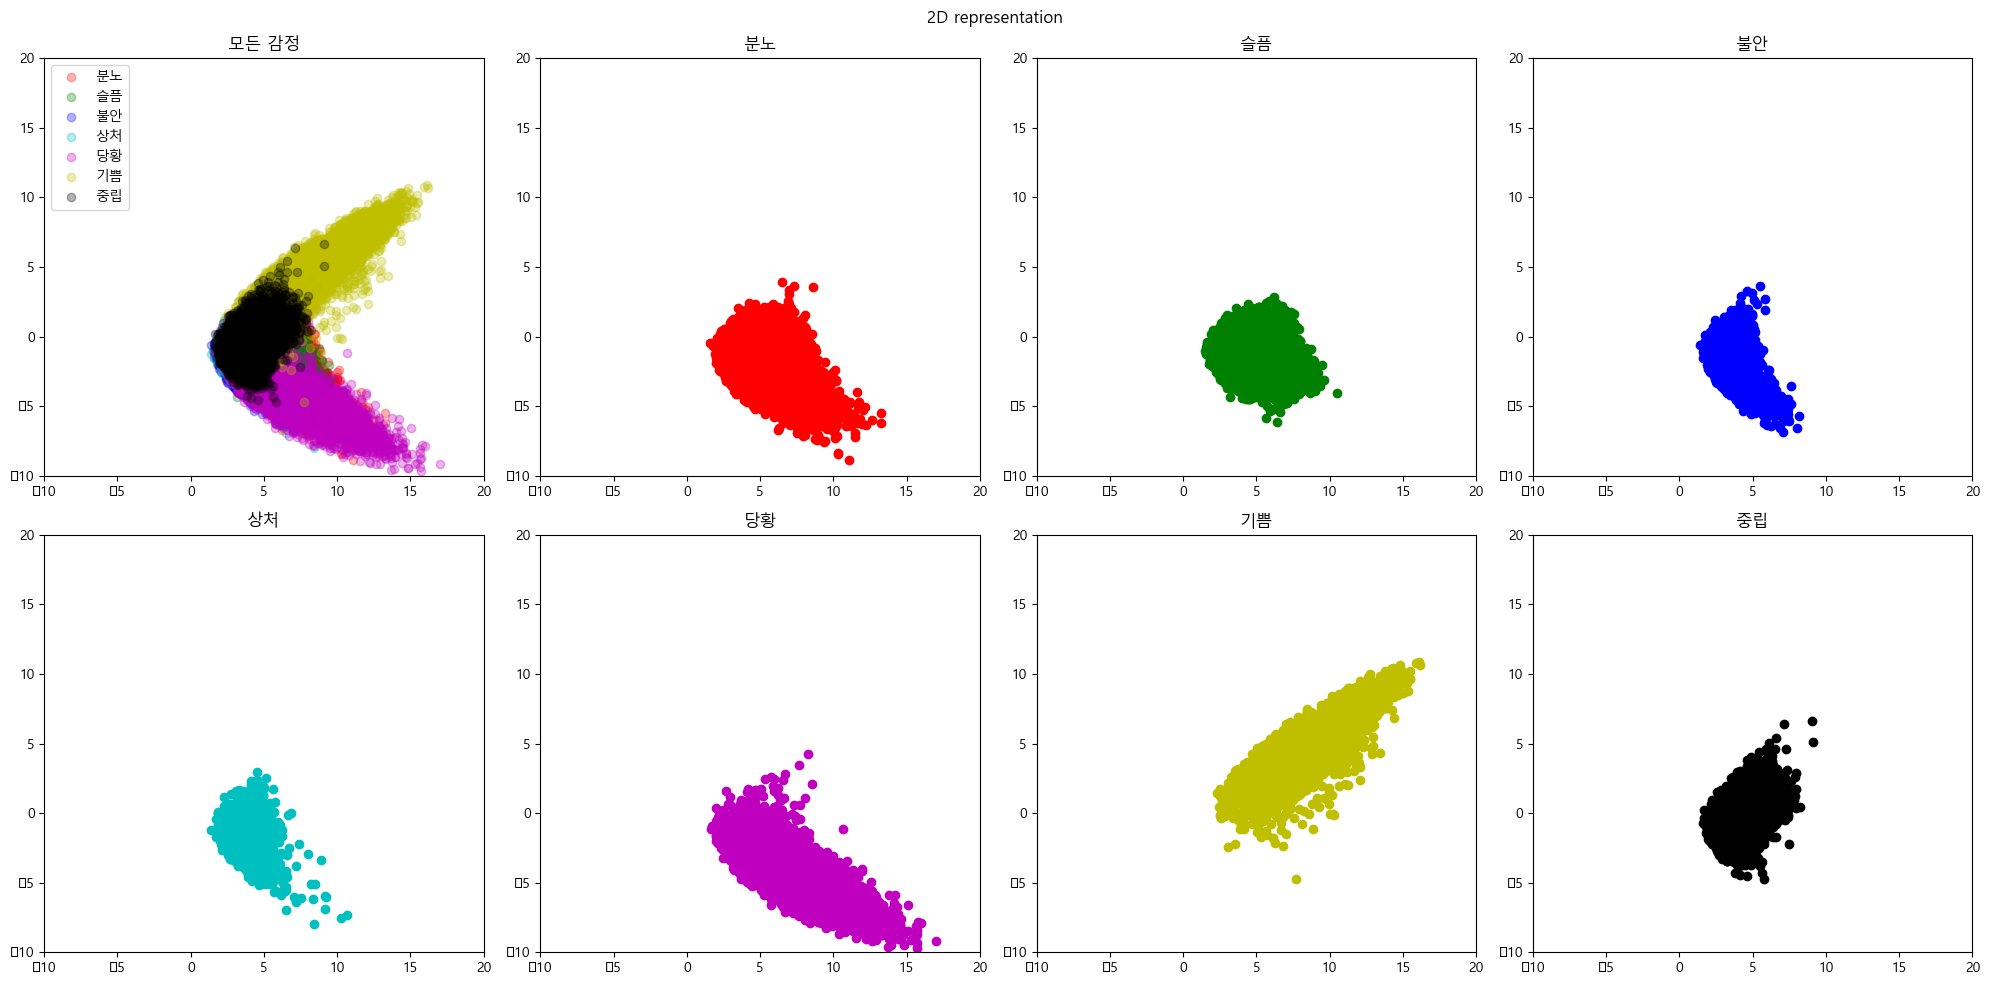

In [60]:
plot_representation(train_svd, train_labels)